In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
dataset_path = "/content/gdrive/My Drive/TK1 AMS/dataset/"
path = "/content/gdrive/My Drive/TK1 AMS/"

In [3]:
!pip install nltk
!pip install plotly
!pip install gensim
!pip install tqdm
!pip install xgboost

import numpy as np
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from collections import OrderedDict, Counter
from wordcloud import WordCloud
from tqdm import tqdm

from gensim import corpora, models, similarities
from gensim.models import CoherenceModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from xgboost import XGBClassifier

nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Collection

In [4]:
df_profile = pd.read_excel(dataset_path+"df_training_labeled_structured.xlsx", usecols=['name','description','occupation'])
df_profile.head()

,description,name,occupation
0,NaN,Atika Mutiara,sosial kemasyarakatan
1,Fearfully and wonderfully made. A traveller bo...,Lolita Agustine,sains dan teknologi
2,Penulis FILOSOFI TERAS. Ketua Umum Partai Kead...,Henry Manampiring,hiburan
3,NaN,Lukman H. Saifuddin,sosial kemasyarakatan
4,Founder of Drone Emprit and Media Kernels Indo...,Ismail Fahmi,sains dan teknologi


In [8]:
df_tweet = pd.read_csv(dataset_path+"df_training_tweet.csv")
df_tweet.head()

,username,tweet
0,_atikamutiara,Why?<SEP>The weekend https://t.co/l011C36osT<...
1,lolitagustine,Life’s special occasions 🌙 https://t.co/7K6KX...
2,newsplatter,Untuk yg lagi hamil: https://t.co/nI01EfH0tc<...
3,lukmansaifuddin,"Di tengah pandemi yang kian menguras emosi, me..."
4,ismailfahmi,@fauklunub @jokopinurbo Blm pernah beli buku p...


In [ ]:
df_tweet = df_tweet.merge(df_profile, left_on='username', right_on='username')

In [59]:
df_non_person = pd.read_excel(dataset_path + "df_training_non_person_labeled_structured.xlsx")
df_non_person.head()

,id,name,username,created_at,description,location,protected,verified,followers_count,following_count,listed_count,tweet_count,occupation
0,3.299332e+09,KRAKATAU STEEL,_KRAKATAUSTEEL,2015-07-28,Indonesian largest integrated steel maker. Est...,"Kota Cilegon, Banten",False,True,8523.0,181.0,21.0,1687.0,ekonomi dan bisnis
1,1.047255e+09,Pamflet,_pamflet,2012-12-30,Membantu anak muda melakukan sesuatu bagi kema...,"Mimosa IV, Blok E17, Jak-Sel",False,False,5664.0,457.0,25.0,6826.0,sosial kemasyarakatan
2,3.514219e+08,TNI Angkatan Laut,_TNIAL_,2011-08-09,This is the Official Indonesian Navy twitter a...,Indonesia,False,True,244087.0,142.0,153.0,8637.0,sosial kemasyarakatan
3,6.008735e+08,TNI Angkatan Udara,_TNIAU,2012-06-06,Akun Twitter Resmi TNI Angkatan Udara | Dikelo...,"Cilangkap, Jakarta - Indonesia",False,True,493079.0,45.0,346.0,53996.0,sosial kemasyarakatan
4,1.446791e+08,UNS Official,11MaretUniv,2010-05-17,Official Account of Universitas Sebelas Maret ...,"Surakarta, Jawa Tengah",False,True,84493.0,121.0,78.0,7435.0,pendidikan dan penelitian


# Exploratory Data Analysis

## Profile Data


In [60]:
##Menggabungkan data profile yang sudah ada dengan data baru 
df_profile = pd.concat([df_profile,df_non_person[["description","name","occupation"]]])
df_profile

,description,name,occupation
1,Fearfully and wonderfully made. A traveller bo...,Lolita Agustine,sains dan teknologi
2,Penulis FILOSOFI TERAS. Ketua Umum Partai Kead...,Henry Manampiring,hiburan
4,Founder of Drone Emprit and Media Kernels Indo...,Ismail Fahmi,sains dan teknologi
6,Dean at @FASILKOM_UI,Mirna Adriani,pendidikan dan penelitian
8,EDM Idol Anime Bootleg Man. @Alter_Synth Resid...,「Alter Synth」Magna,sains dan teknologi
...,...,...,...
910,Yayasan Lembaga Bantuan Hukum Indonesia yang m...,YayasanLBHIndonesia,sosial kemasyarakatan
911,"Kalo bisa sukses di usia muda, kenapa nunggu tua?",Young On Top,sosial kemasyarakatan
912,like and subscribe.,YouTube,ekonomi dan bisnis
913,"Asia's Leading Online Fashion, Beauty and Life...",ZALORA,ekonomi dan bisnis


In [ ]:
df_profile.isnull().sum()

## Tweet Data


In [ ]:
df_tweet.sample(5)

In [ ]:
df_tweet.shape

(10867, 2)

In [ ]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10867 entries, 0 to 10866
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  10867 non-null  object
 1   tweet     10597 non-null  object
dtypes: object(2)
memory usage: 169.9+ KB


In [ ]:
df_tweet.isnull().sum()

username      0
tweet       270
dtype: int64

In [ ]:
df_tweet.describe()

,username,tweet
count,10867,10597
unique,10867,10597
top,_atikamutiara,Why?<SEP>The weekend https://t.co/l011C36osT<...
freq,1,1


## Occupational Area Ratio


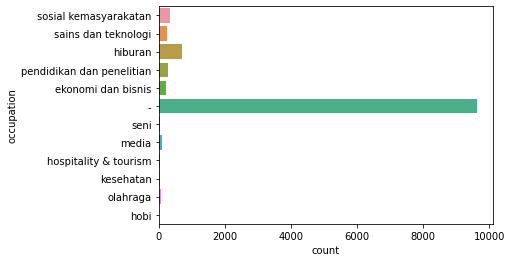

In [ ]:
sns.countplot(y='occupation', data=df_profile)
plt.show()

In [ ]:
df_profile["occupation"].value_counts()

-                            9644
hiburan                       703
sosial kemasyarakatan         350
pendidikan dan penelitian     277
sains dan teknologi           263
ekonomi dan bisnis            228
media                         110
olahraga                       83
hospitality & tourism          37
seni                           36
kesehatan                      30
hobi                           21
Name: occupation, dtype: int64

# Data Preprocessing

### User Profile

<p>Melakukan pemrosesan data teks agar dapat dipelajari oleh model.</p>
<p>Drop null/nana values pada fitur name dan description. </p>



In [7]:
no_name_idx = df_profile[df_profile['name'].isnull()].index
df_profile.drop(no_name_idx, inplace=True)
df_profile = df_profile.dropna(subset=['description'])
df_profile.head()

,description,name,occupation
1,Fearfully and wonderfully made. A traveller bo...,Lolita Agustine,sains dan teknologi
2,Penulis FILOSOFI TERAS. Ketua Umum Partai Kead...,Henry Manampiring,hiburan
4,Founder of Drone Emprit and Media Kernels Indo...,Ismail Fahmi,sains dan teknologi
6,Dean at @FASILKOM_UI,Mirna Adriani,pendidikan dan penelitian
8,EDM Idol Anime Bootleg Man. @Alter_Synth Resid...,「Alter Synth」Magna,sains dan teknologi


## User Tweet

Memilih atribut yang akan diproses dan dipelajari oleh model.

In [60]:
df_res_tweet = df_tweet[['tweet', 'occupation']]

In [ ]:
no_gender_idx = df_res_tweet[df_res_tweet['occupation'] == '-'].index
df_res_tweet.drop(no_gender_idx, inplace=True)

In [ ]:
no_tweet_idx = df_res_tweet[df_res_tweet['tweet'].isnull()].index
df_res_tweet.drop(no_tweet_idx, inplace=True)

In [ ]:
df_res_tweet['num_tweet'] = df_res_tweet['tweet'].apply(lambda tweet: len(tweet.split("<SEP>")))

In [ ]:
for idx, row in df_res_tweet.iterrows():

  # split each tweet into a list of tweets
  list_tweet = row['tweet'].split("<SEP>")

  # set the limit to max 250
  if row['num_tweet'] > 250:
    random_list_tweet = np.random.choice(list_tweet, 250, replace=False)
    df_res_tweet.at[idx, 'tweet'] = ' '.join(random_list_tweet)
  else:
    df_res_tweet.at[idx, 'tweet'] =' '.join(list_tweet)

## Cleaning Data

In [11]:
def clean_data(tweet):
    # lowercase
    normal_tw = tweet.lower()
    # hapus b'
    normal_tw = re.sub(r'^b\'', '', normal_tw)
    # hapus RT
    normal_tw = re.sub(r'^rt ', '', normal_tw)
    # hapus emoji
    normal_tw = re.sub(r'\\x.{2}', '', normal_tw)
    # hapus www.* atau https?://* (URL)
    normal_tw = re.sub(r'((www\.[^\s]*)|(https?://[^\s]*))', '', normal_tw)
    # remove spasi berlebih
    normal_tw = re.sub(r'\s+', ' ', normal_tw)
    # trim depan belakang
    normal_tw = normal_tw.strip()
    # regex huruf yang berulang kaya haiiii (untuk fitur unigram)
    normal_regex = re.compile(r"(.)\1{1,}")
    # buang huruf yang berulang
    normal_tw = normal_regex.sub(r"\1\1", normal_tw)
    # hapus @username
    normal_tw = re.sub(r'@[^\s]+', '', normal_tw)
    # hapus hashtag
    normal_tw = re.sub(r'#[^\s]+', '', normal_tw)
    # hapus tanda baca
    normal_tw = re.sub(r'[^\w\s]', '', normal_tw) 
    # hapus angka
    normal_tw = re.sub(r'\d+', ' ', normal_tw) 
    return normal_tw

def remove_stopwords_and_normalize(tweet):
    token = nltk.word_tokenize(tweet)
    token_new = []
    for k in token:
        if k in df_kamus_singkatan['singkatan'].values:
            k = df_kamus_singkatan.loc[df_kamus_singkatan['singkatan']
                                       == k, 'asli'].values[0]
        if k in df_kamus_alay['slang'].values:
            k = df_kamus_alay.loc[df_kamus_alay['slang']
                                  == k, 'formal'].values[0]
        if k not in stopwords[0].values:
            token_new.append(k)

    str_clean = ' '.join(token_new)
    return str_clean

def pra_pemrosesan(list_tweet):
    tweet_clean = []
    for tw in tqdm(list_tweet):
        normal_tweet = clean_data(tw)
        normal_tweet = remove_stopwords_and_normalize(normal_tweet)
        tweet_clean.append(normal_tweet)
    return tweet_clean

In [12]:
# Mengambil data
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1rFLB_1QpZhKyWFGxqPo5znTEkh7dUhPf' -O dataset.csv
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xEIQwYre1SR71uRdQuez9MDmAUIysvAG' -O stopwordsID.csv
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=19NOzXA8Voturopg_DTuiMns3s4M2IAUz' -O kamus_singkatan.csv
!wget -q --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VjgivEr1pxyRCuyhVifPnaReFz0yd8Us' -O colloquial-indonesian-lexicon.csv

In [13]:
stopwords = pd.read_csv("stopwordsID.csv", header=None)
df_kamus_singkatan = pd.read_csv('kamus_singkatan.csv')
df_kamus_alay = pd.read_csv('colloquial-indonesian-lexicon.csv')

In [11]:
profile_name = df_profile['name']
clean_tweet_name = np.array(pra_pemrosesan(profile_name))
profile_desc = df_profile['description']
clean_tweet_desc = np.array(pra_pemrosesan(profile_desc))

100%|██████████| 8221/8221 [00:28<00:00, 283.66it/s]


In [12]:
df_profile_clean = pd.DataFrame({
    'name' : clean_tweet_name,
    'description': clean_tweet_desc,
    'occupation': df_profile['occupation'],
})

In [ ]:
raw_tweet = df_res_tweet['tweet']
clean_tweet = np.array(pra_pemrosesan(raw_tweet))

100%|██████████| 1090/1090 [24:31<00:00,  1.35s/it]


In [ ]:
df_res = pd.DataFrame({
    'tweet': clean_tweet,
    'occupation': df_res_tweet['occupation'],
})

In [ ]:
df_res.to_csv(path+'CODE/df_clean_tweet_occupation.csv')

In [4]:
# load clean data
df_res_tweet = pd.read_csv(path+'df_clean_tweet_occupation.csv')

In [5]:
na_tweet_idx = df_res_tweet[df_res_tweet['tweet'].isna()].index
df_res_tweet.drop(na_tweet_idx, inplace=True)

In [6]:
df_res_tweet["occupation"].value_counts()

hiburan                      541
sains dan teknologi          164
sosial kemasyarakatan        145
pendidikan dan penelitian     81
ekonomi dan bisnis            80
media                         20
hospitality & tourism         20
seni                          19
kesehatan                     19
Name: occupation, dtype: int64

> Dari hasil diatas terlihat bahwa aspek olahraga menghilang karena proses cleaning pada atribut tweet

## Load Additional Data

### Load Additional Data Profile dengan menghitung kemunculan kata pada fitur description

<p>Untuk mengatasi permaasalahan banyak nilai terbuang karena pada fitur occupation banyak memiliki nilai "-" maka kami mencoba menambah data training dengan mengisi nilai null pada atribut pekerjaan tersebut dengan mengambil suatu jenis pekerjaan berdasarkan nilai maksimal jumlah kata yang muncul pada fitur description pada list gabungan dari setiap jenis pekerjaan yang sudah ada</p>

In [7]:
df_profile_clean = df_profile_clean[df_profile_clean['occupation'] != 'hobi']
df_profile_clean["occupation"].value_counts()

In [14]:
df_without_empty = df_profile_clean.copy()
no_occ_idx = df_without_empty[df_without_empty['occupation'] == '-'].index
df_without_empty.drop(no_occ_idx, inplace=True)

In [15]:
df_without_empty_join =  df_without_empty.groupby('occupation', as_index=False).agg(' '.join)
df_without_empty_join["description"] = df_without_empty_join["description"].str.split(" ")
df_without_empty_join.head()

,occupation,name,description
0,ekonomi dan bisnis,ᴏᴋᴛᴀᴠɪᴀɴᴜs geraldy jess jessica b michelle ima...,"[yogyakarta, ig, misqueen, edgy, ceo, budaq, k..."
1,hiburan,henry manampiring sarah hadju ria winata ayu s...,"[penulis, filosofi, teras, ketua, partai, kead..."
2,hospitality & tourism,fellya hartono ariefpokto iqbalkautsarcom atan...,"[former, net, journalist, videographer, video,..."
3,kesehatan,adibkhumaidi aminuddin hamzah hafiq arif sabta...,"[president, elect, ima, idi, orthopedic, and, ..."
4,media,helmi johannes christina helen stanley widiant...,"[tv, journalist, world, traveler, license, pla..."


In [16]:
list_occ_words_dict = dict()

for _, row in df_without_empty_join.iterrows():
  list_occ_words_dict[row['occupation']] = row['description']

In [17]:
list_unique_occ = list(list_occ_words_dict.keys())
word_occ_counter_dict = dict()

for occ in list_unique_occ:
  list_counter = []
  for _, row in df_profile_clean.iterrows():
    list_tweet = row['description'].split(" ")
    counter = 0

    for word in list_tweet:
      if word in list_occ_words_dict[occ]:
        counter += 1
      else:
        continue
    
    list_counter.append(counter)

  word_occ_counter_dict[f"{occ}"] = list_counter

In [18]:
count = pd.DataFrame(word_occ_counter_dict)
df_profile_clean= df_profile_clean.reset_index(inplace = False)
df_profile_clean.drop(df_profile_clean.columns[[0]], axis=1, inplace=True)

In [19]:
df_res_profile = pd.concat([df_profile_clean,count], axis=1)
df_res_profile.head()

,name,description,occupation,ekonomi dan bisnis,hiburan,hospitality & tourism,kesehatan,media,olahraga,pendidikan dan penelitian,sains dan teknologi,seni,sosial kemasyarakatan
0,lolita agustine,fearfully and wonderfully made a traveller bot...,sains dan teknologi,3,5,5,4,1,4,3,10,0,3
1,henry manampiring,penulis filosofi teras ketua partai keadilan k...,hiburan,2,8,0,0,0,0,0,0,0,3
2,ismail fahmi,founder of drone emprit and media kernels indo...,sains dan teknologi,4,5,4,3,3,3,5,8,3,5
3,mirna adriani,dean at,pendidikan dan penelitian,1,1,0,1,1,0,2,1,0,1
4,alter synthmagna,edm idol anime bootleg man resident spearhead ...,sains dan teknologi,4,10,3,4,4,4,5,20,2,5


In [20]:
df_profile_fill_empty = df_res_profile[df_res_profile['occupation'] == '-']
df_profile_fill_empty.rename(columns = {'ekonomi dan bisnis':'ekbis', 'hospitality & tourism':'hostour',
'pendidikan dan penelitian':'pendidikan', 'sains dan teknologi':'sastek','sosial kemasyarakatan':'sosmas'}, inplace = True)
df_profile_fill_empty['occupation']= df_profile_fill_empty.eq(df_profile_fill_empty.max(axis=1), axis=0).apply(lambda x: ' '.join(df_profile_fill_empty.columns[x]), axis=1)
occ_1= df_profile_fill_empty['occupation'].str.strip().str.split(' ').str.len().eq(1)
df_profile_fill_empty=df_profile_fill_empty[occ_1]
df_profile_fill_empty.rename(columns = {'ekbis':'ekonomi dan bisnis','hostour':'hospitality & tourism',
'pendidikan':'pendidikan dan penelitian', 'sastek':'sains dan teknologi','sosmas':'sosial kemasyarakatan'}, inplace = True)
code = {"ekbis" :"ekonomi dan bisnis", "sosmas" : "sosial kemasyarakatan", "hostour":"hospitality & tourism","pendidikan":"pendidikan dan penelitian",
        "sains":"sains dan teknologi","hiburan":"hiburan","seni":"seni","media":"media","kesehatan":"kesehatan","olahraga":"olahraga"}
df_profile_fill_empty['occupation'] = df_profile_fill_empty['occupation'].map(code)
df_profile_fill_empty.shape

(3304, 13)

In [21]:
df_without_empty_count = df_res_profile.copy()
no_occ_idx = df_res_profile[df_res_profile['occupation'] == '-'].index
df_without_empty_count.drop(no_occ_idx, inplace=True)
df_profile_count_fill = pd.concat([df_without_empty_count,df_profile_fill_empty])
df_profile_count_fill = df_profile_count_fill.dropna(subset=['occupation'])
df_profile_count_fill.shape

(4120, 13)

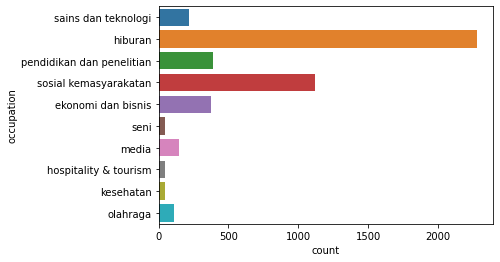

In [28]:
sns.countplot(y='occupation', data=df_profile_count_fill)
plt.show()

### Load Additional Data Tweet dengan data olahraga

Untuk mengatasi permasalahan aspek olahraga yang menghilang karena hasil proses cleaning maka kami menambahkan data olahraga menggunakan teknik crawling data tweet menggunakan tweepy(code berada pada file crawling_olahraga)

In [8]:
sport_df = pd.read_csv(path+"olahraga.csv", header=None)
sport_df.columns = ['username', 'tweet']

In [14]:
stopwords = pd.read_csv("stopwordsID.csv", header=None)
df_kamus_singkatan = pd.read_csv('kamus_singkatan.csv')
df_kamus_alay = pd.read_csv('colloquial-indonesian-lexicon.csv')

raw_sport_tweet = sport_df['tweet']
clean_sport_tweet = np.array(pra_pemrosesan(raw_sport_tweet))

100%|██████████| 11/11 [00:07<00:00,  1.39it/s]


In [15]:
clean_sport_tweet = np.delete(clean_sport_tweet, 0)
clean_sport_tweet[:3]

array(['bahasa samasama semangat belajar bahasa korea haha bahasa jepang gaess fyi f 그냥 항상 화이팅 mexico 에서 조심하세요 왜 안가 루이는 언니에게 간다고 말했어 f f f f 네 힘내 화이팅 인도네시아 만날수있어 축하해 루이 mengeditnya merinding kak nnmenurut konten terkeren sih hahahahannfull renungan malam kak kak apri f terima kasih kbri inggris tumpangannya nwhat a lovely time menikmati mingguminggu badan tersiksa for almost years been feeling like this wkwkwkwk pertanyaanku foto tersebar had a great time sharing the moments at the stage sih you again next time tim putri indonesia mengukir sejarah menjuarai badminton asia team championship mengerti speechless diam emas terima kasih diam f adikadik terimakasihh streaming live batc pleasee a message from your new bwf athletes commission chair served be a serving olympic champions and apriyani rahayu reveal how their unique relationship propelled them the biggest prize temans pelatnas ditahun alasan kepentingan pribadiku nnkalau memikirkan kepentingan pribadi mah tempatnya teman hahahaha 

In [16]:
df_clean_sport = pd.DataFrame({
    'tweet': clean_sport_tweet,
    'occupation': np.array(['olahraga' for _ in range(10)])
})

In [17]:
df_clean_sport

,tweet,occupation
0,bahasa samasama semangat belajar bahasa korea ...,olahraga
1,happy good friday hahahah iya wkwkwkwk stres l...,olahraga
2,setuju pemakaian kredit istimewa media wajib m...,olahraga
3,sobatpora mengalami masamasa sulit percayalah ...,olahraga
4,presenting the indian squad for the and after ...,olahraga
5,robert simón ex del b el año pasado ha fichado...,olahraga
6,kabar piala wali kota solo digelar ajang pramu...,olahraga
7,part of mnc channelsnnjelang sea games nkita n...,olahraga
8,chelsea vs arsenal eddie nketiah gemilang mike...,olahraga
9,ubah pola hidup jantung sehat nselamat preside...,olahraga


In [18]:
df_res_tweet = pd.concat([df_res_tweet, df_clean_sport], ignore_index=True)
df_res_tweet['occupation'].value_counts()

hiburan                      541
sains dan teknologi          164
sosial kemasyarakatan        145
pendidikan dan penelitian     81
ekonomi dan bisnis            80
media                         20
hospitality & tourism         20
seni                          19
kesehatan                     19
olahraga                      10
Name: occupation, dtype: int64

## Spliting Data

In [ ]:
#Schema 1 -> Fitur Description
X_desc = df_without_empty['description']
y_desc = df_without_empty['occupation']
X_train_desc, X_test_desc, y_train_desc, y_test_desc = train_test_split(X_desc, y_desc, test_size=0.2, stratify=y_desc, random_state=42)

In [ ]:
#Schema 2-> Fitur description dengan count
X_desc_count = df_without_empty_count['description']
y_desc_count = df_without_empty_count['occupation']
X_train_desc_count, X_test_desc_count, y_train_desc_count, y_test_desc_count = train_test_split(X_desc_count, y_desc_count, test_size=0.2, stratify=y_desc_count, random_state=42)

In [22]:
#Schema 3-> Fitur description dengan fill null occupation dengan max count
X_desc_fill = df_profile_count_fill['description']
y_desc_fill = df_profile_count_fill['occupation']
X_train_fill, X_test_fill, y_train_fill, y_test_fill = train_test_split(X_desc_fill, y_desc_fill, test_size=0.2, stratify=y_desc_fill, random_state=42)

In [55]:
#Schema 4-> Fitur tweet
X_tweet = df_res_tweet['tweet']
y_tweet = df_res_tweet['occupation']
X_train_tweet, X_test_tweet, y_train_tweet, y_test_tweet = train_test_split(X_tweet, y_tweet, test_size=0.2, stratify=y_tweet, random_state=42)

## Feature Extraction

In [22]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
over = SMOTE()

### Schema 1(Fitur Description)

In [ ]:
vectorizer_desc_tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=75000)
vectorizer_desc_tfidf.fit(X_train_desc)

X_train_desc = vectorizer_desc_tfidf.transform(X_train_desc).todense()
X_test_desc = vectorizer_desc_tfidf.transform(X_test_desc).todense()

In [ ]:
X_train_final_desc, y_train_ovs_desc = over.fit_resample(X_train_desc, y_train_desc)

In [ ]:
del X_train_desc , y_train_desc

### Schema 2 (Fitur Description dan jumlah kata)

In [ ]:
vectorizer_desc_count_tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=75000)
vectorizer_desc_count_tfidf.fit(X_train_desc_count)

X_train_desc_count = vectorizer_desc_count_tfidf.transform(X_train_desc_count).todense()
X_test_desc_count = vectorizer_desc_count_tfidf.transform(X_test_desc_count).todense()

In [ ]:
X_train_final_desc_count, y_train_ovs_desc_count = over.fit_resample(X_train_desc_count, y_train_desc_count)

In [ ]:
del X_train_desc_count , y_train_desc_count

### Schema 3 (Fitur Description dan fill null values)

In [24]:
vectorizer_desc_fill_tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=30000)
vectorizer_desc_fill_tfidf.fit(X_train_fill)

X_train_fill = vectorizer_desc_fill_tfidf.transform(X_train_fill).todense()
X_test_fill = vectorizer_desc_fill_tfidf.transform(X_test_fill).todense()

In [25]:
X_train_final_fill, y_train_ovs_fill = over.fit_resample(X_train_fill, y_train_fill)

In [26]:
del X_train_fill , y_train_fill

### Schema 4 (Fitur tweet)

In [58]:
vectorizer_tweet_tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=75000)
vectorizer_tweet_tfidf.fit(X_train_tweet)

X_train_tweet = vectorizer_tweet_tfidf.transform(X_train_tweet).todense()
X_test_tweet = vectorizer_tweet_tfidf.transform(X_test_tweet).todense()

In [23]:
X_train_final_tweet, y_train_ovs_tweet = over.fit_resample(X_train_tweet, y_train_tweet)

In [24]:
del X_train_tweet , y_train_tweet

# Data Modeling

In [26]:
# from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
# from sklearn.metrics import accuracy_score

https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

## Logistic Regression

### Schema 1(Fitur Description)

In [ ]:
logreg_clf = OneVsRestClassifier(LogisticRegression(solver='sag'))
logreg_clf.fit(X_train_final_desc, y_train_ovs_desc)
logreg_ypred = logreg_clf.predict(X_test_desc)

In [ ]:
print(classification_report(logreg_ypred, y_test_desc))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.24      0.21      0.23        38
                  hiburan       0.62      0.59      0.60       122
    hospitality & tourism       0.43      0.75      0.55         4
                kesehatan       0.20      1.00      0.33         1
                    media       0.58      0.58      0.58        12
                 olahraga       0.18      0.22      0.20         9
pendidikan dan penelitian       0.38      0.65      0.48        23
      sains dan teknologi       0.27      0.17      0.21        60
                     seni       0.40      0.50      0.44         4
    sosial kemasyarakatan       0.34      0.40      0.37        40

                 accuracy                           0.43       313
                macro avg       0.36      0.51      0.40       313
             weighted avg       0.43      0.43      0.43       313



### Schema 2 (Fitur Description dan jumlah kata)

In [ ]:
logreg_clf = OneVsRestClassifier(LogisticRegression(solver='sag'))
logreg_clf.fit(X_train_final_desc_count, y_train_ovs_desc_count)
logreg_ypred = logreg_clf.predict(X_test_desc_count)

In [ ]:
print(classification_report(logreg_ypred, y_test_desc_count))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.19      0.29      0.23        28
                  hiburan       0.56      0.56      0.56       126
    hospitality & tourism       0.43      0.75      0.55         4
                kesehatan       0.33      1.00      0.50         2
                    media       0.50      0.35      0.42        31
                 olahraga       0.31      0.22      0.26        23
pendidikan dan penelitian       0.48      0.59      0.53        41
      sains dan teknologi       0.30      0.22      0.25        59
                     seni       0.57      0.67      0.62         6
    sosial kemasyarakatan       0.47      0.48      0.48        64

                 accuracy                           0.45       384
                macro avg       0.41      0.51      0.44       384
             weighted avg       0.45      0.45      0.44       384



### Schema 3 (Fitur Description dan fill null values)

In [28]:
logreg_clf = OneVsRestClassifier(LogisticRegression(solver='sag'))
logreg_clf.fit(X_train_final_fill, y_train_ovs_fill)
logreg_ypred = logreg_clf.predict(X_test_fill)

In [29]:
print(classification_report(logreg_ypred, y_test_fill))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.73      0.62      0.67        39
                  hiburan       0.84      0.87      0.85       520
    hospitality & tourism       0.17      0.33      0.22         3
                kesehatan       0.75      0.75      0.75         8
                    media       0.50      1.00      0.67         3
                 olahraga       0.29      1.00      0.44         2
pendidikan dan penelitian       0.33      0.33      0.33        18
      sains dan teknologi       0.33      0.15      0.21        67
                     seni       0.20      0.50      0.29         2
    sosial kemasyarakatan       0.76      0.81      0.79       162

                 accuracy                           0.77       824
                macro avg       0.49      0.64      0.52       824
             weighted avg       0.76      0.77      0.76       824



### Schema 4 (Fitur tweet)

In [27]:
logreg_clf = OneVsRestClassifier(LogisticRegression(solver='sag'))
logreg_clf.fit(X_train_final_tweet, y_train_ovs_tweet)
logreg_ypred = logreg_clf.predict(X_test_tweet)

In [28]:
print(classification_report(logreg_ypred, y_test_tweet))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.19      0.23      0.21        13
                  hiburan       0.82      0.74      0.78       120
    hospitality & tourism       0.25      0.33      0.29         3
                kesehatan       0.00      0.00      0.00         1
                    media       0.00      0.00      0.00         0
                 olahraga       1.00      1.00      1.00         2
pendidikan dan penelitian       0.19      0.25      0.21        12
      sains dan teknologi       0.27      0.29      0.28        31
                     seni       0.50      1.00      0.67         2
    sosial kemasyarakatan       0.55      0.44      0.49        36

                 accuracy                           0.57       220
                macro avg       0.38      0.43      0.39       220
             weighted avg       0.62      0.57      0.59       220



In [ ]:
import pickle
filename = 'model_occupation_logreg_tweet.sav'
pickle.dump(logreg_clf , open(filename, 'wb'))

## Multinomial NB

### Schema 1(Fitur Description)

In [ ]:
multinb_clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))

multinb_clf.fit(X_train_final_desc, y_train_ovs_desc)

mnb_ypred = multinb_clf.predict(X_test_desc)

In [ ]:
print(classification_report(mnb_ypred, y_test_desc))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.12      0.21      0.15        19
                  hiburan       0.37      0.72      0.49        60
    hospitality & tourism       0.57      0.13      0.22        30
                kesehatan       0.40      0.09      0.15        22
                    media       0.75      0.26      0.39        34
                 olahraga       0.36      0.21      0.27        19
pendidikan dan penelitian       0.36      0.58      0.44        24
      sains dan teknologi       0.05      0.11      0.07        19
                     seni       0.40      0.09      0.14        23
    sosial kemasyarakatan       0.51      0.38      0.44        63

                 accuracy                           0.35       313
                macro avg       0.39      0.28      0.28       313
             weighted avg       0.43      0.35      0.33       313



### Schema 2 (Fitur Description dan jumlah kata)

In [ ]:
multinb_clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))

multinb_clf.fit(X_train_final_desc_count, y_train_ovs_desc_count)

mnb_ypred = multinb_clf.predict(X_test_desc_count)

In [ ]:
print(classification_report(mnb_ypred, y_test_desc_count))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.14      0.33      0.20        18
                  hiburan       0.35      0.62      0.45        71
    hospitality & tourism       0.43      0.08      0.13        38
                kesehatan       0.50      0.14      0.22        21
                    media       0.59      0.35      0.44        37
                 olahraga       0.44      0.18      0.25        39
pendidikan dan penelitian       0.54      0.60      0.57        45
      sains dan teknologi       0.11      0.38      0.18        13
                     seni       0.86      0.21      0.34        28
    sosial kemasyarakatan       0.48      0.43      0.46        74

                 accuracy                           0.38       384
                macro avg       0.45      0.33      0.32       384
             weighted avg       0.47      0.38      0.37       384



### Schema 3 (Fitur Description dan fill null values)

In [30]:
multinb_clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))

multinb_clf.fit(X_train_final_fill, y_train_ovs_fill)

mnb_ypred = multinb_clf.predict(X_test_fill)

In [31]:
print(classification_report(mnb_ypred, y_test_fill))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.73      0.73      0.73        33
                  hiburan       0.70      0.93      0.80       404
    hospitality & tourism       0.83      0.14      0.23        37
                kesehatan       0.88      0.26      0.40        27
                    media       1.00      0.35      0.52        17
                 olahraga       0.86      0.18      0.30        33
pendidikan dan penelitian       0.33      0.18      0.24        33
      sains dan teknologi       0.17      0.18      0.17        28
                     seni       0.60      0.13      0.21        23
    sosial kemasyarakatan       0.79      0.72      0.76       189

                 accuracy                           0.70       824
                macro avg       0.69      0.38      0.44       824
             weighted avg       0.71      0.70      0.66       824



### Schema 4 (Fitur tweet)

In [29]:
multinb_clf = OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))

multinb_clf.fit(X_train_final_tweet, y_train_ovs_tweet)

mnb_ypred = multinb_clf.predict(X_test_tweet)

In [30]:
print(classification_report(mnb_ypred, y_test_tweet))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.50      0.21      0.29        39
                  hiburan       0.55      0.87      0.67        68
    hospitality & tourism       0.50      0.15      0.24        13
                kesehatan       0.50      0.50      0.50         4
                    media       1.00      0.44      0.62         9
                 olahraga       1.00      1.00      1.00         2
pendidikan dan penelitian       0.06      0.11      0.08         9
      sains dan teknologi       0.36      0.32      0.34        38
                     seni       0.50      0.20      0.29        10
    sosial kemasyarakatan       0.52      0.54      0.53        28

                 accuracy                           0.49       220
                macro avg       0.55      0.43      0.45       220
             weighted avg       0.50      0.49      0.46       220



In [ ]:
filename = 'model_occupation_multinomialnb_tweet.sav'
pickle.dump(multinb_clf , open(filename, 'wb'))

## Random Forest Classifier

### Schema 1(Fitur Description)

In [ ]:
rfc_clf = OneVsOneClassifier(RandomForestClassifier())

rfc_clf.fit(X_train_final_desc, y_train_ovs_desc)

rfc_ypred = rfc_clf.predict(X_test_desc)

In [ ]:
print(classification_report(rfc_ypred, y_test_desc))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.27      0.13      0.17        70
                  hiburan       0.62      0.44      0.51       167
    hospitality & tourism       0.00      0.00      0.00         0
                kesehatan       0.00      0.00      0.00         0
                    media       0.00      0.00      0.00         1
                 olahraga       0.00      0.00      0.00         1
pendidikan dan penelitian       0.31      0.71      0.43        17
      sains dan teknologi       0.14      0.13      0.13        38
                     seni       0.00      0.00      0.00         0
    sosial kemasyarakatan       0.26      0.63      0.36        19

                 accuracy                           0.35       313
                macro avg       0.16      0.20      0.16       313
             weighted avg       0.44      0.35      0.37       313



### Schema 2 (Fitur Description dan jumlah kata)

In [ ]:
rfc_clf = OneVsOneClassifier(RandomForestClassifier())

rfc_clf.fit(X_train_final_desc_count, y_train_ovs_desc_count)

rfc_ypred = rfc_clf.predict(X_test_desc_count)

In [ ]:
print(classification_report(rfc_ypred, y_test_desc_count))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.14      0.21      0.17        29
                  hiburan       0.62      0.44      0.51       176
    hospitality & tourism       0.00      0.00      0.00         0
                kesehatan       0.00      0.00      0.00         0
                    media       0.09      0.50      0.15         4
                 olahraga       0.12      0.67      0.21         3
pendidikan dan penelitian       0.38      0.83      0.52        23
      sains dan teknologi       0.43      0.17      0.25       111
                     seni       0.00      0.00      0.00         0
    sosial kemasyarakatan       0.44      0.76      0.56        38

                 accuracy                           0.40       384
                macro avg       0.22      0.36      0.24       384
             weighted avg       0.49      0.40      0.41       384



### Schema 3 (Fitur Description dan fill null values)

In [32]:
rfc_clf = OneVsOneClassifier(RandomForestClassifier())

rfc_clf.fit(X_train_final_fill, y_train_ovs_fill)

rfc_ypred = rfc_clf.predict(X_test_fill)

In [33]:
print(classification_report(rfc_ypred, y_test_fill))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.36      0.50      0.42        24
                  hiburan       0.79      0.83      0.81       510
    hospitality & tourism       0.00      0.00      0.00         0
                kesehatan       0.25      1.00      0.40         2
                    media       0.00      0.00      0.00         0
                 olahraga       0.00      0.00      0.00         0
pendidikan dan penelitian       0.11      0.29      0.16         7
      sains dan teknologi       0.57      0.11      0.18       158
                     seni       0.20      1.00      0.33         1
    sosial kemasyarakatan       0.63      0.89      0.74       122

                 accuracy                           0.69       824
                macro avg       0.29      0.46      0.30       824
             weighted avg       0.70      0.69      0.66       824



### Schema 4 (Fitur tweet)

In [31]:
rfc_clf = OneVsOneClassifier(RandomForestClassifier())

rfc_clf.fit(X_train_final_tweet, y_train_ovs_tweet)

rfc_ypred = rfc_clf.predict(X_test_tweet)

In [32]:
print(classification_report(rfc_ypred, y_test_tweet))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.00      0.00      0.00         0
                  hiburan       0.94      0.57      0.71       180
    hospitality & tourism       0.00      0.00      0.00         0
                kesehatan       0.00      0.00      0.00         0
                    media       0.00      0.00      0.00         0
                 olahraga       0.00      0.00      0.00         0
pendidikan dan penelitian       0.00      0.00      0.00         0
      sains dan teknologi       0.15      0.38      0.22        13
                     seni       0.50      1.00      0.67         2
    sosial kemasyarakatan       0.45      0.52      0.48        25

                 accuracy                           0.55       220
                macro avg       0.20      0.25      0.21       220
             weighted avg       0.84      0.55      0.65       220



In [ ]:
filename = 'model_occupation_rf_tweet.sav'
pickle.dump(rfc_clf , open(filename, 'wb'))

##LGBM Classifier

### Schema 1(Fitur Description)

In [34]:
from lightgbm import LGBMClassifier

In [ ]:
lgb_clf = LGBMClassifier()

lgb_clf.fit(X_train_final_desc, y_train_ovs_desc)

lgb_ypred = lgb_clf.predict(X_test_desc)

In [ ]:
print(classification_report(lgb_ypred, y_test_desc))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.18      0.25      0.21        24
                  hiburan       0.54      0.49      0.51       129
    hospitality & tourism       0.29      0.67      0.40         3
                kesehatan       0.20      0.33      0.25         3
                    media       0.50      0.55      0.52        11
                 olahraga       0.00      0.00      0.00         0
pendidikan dan penelitian       0.38      0.45      0.42        33
      sains dan teknologi       0.24      0.12      0.16        76
                     seni       0.20      0.20      0.20         5
    sosial kemasyarakatan       0.32      0.52      0.39        29

                 accuracy                           0.38       313
                macro avg       0.29      0.36      0.31       313
             weighted avg       0.39      0.38      0.37       313



### Schema 2 (Fitur Description dan jumlah kata)

In [ ]:
lgb_clf = LGBMClassifier()

lgb_clf.fit(X_train_final_desc_count, y_train_ovs_desc_count)

lgb_ypred = lgb_clf.predict(X_test_desc_count)

In [ ]:
print(classification_report(lgb_ypred, y_test_desc_count))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.19      0.35      0.25        23
                  hiburan       0.59      0.49      0.53       149
    hospitality & tourism       0.14      1.00      0.25         1
                kesehatan       0.17      0.25      0.20         4
                    media       0.55      0.57      0.56        21
                 olahraga       0.19      0.27      0.22        11
pendidikan dan penelitian       0.50      0.52      0.51        48
      sains dan teknologi       0.34      0.20      0.25        75
                     seni       0.57      0.67      0.62         6
    sosial kemasyarakatan       0.38      0.54      0.45        46

                 accuracy                           0.43       384
                macro avg       0.36      0.49      0.38       384
             weighted avg       0.46      0.43      0.44       384



### Schema 3 (Fitur Description dan fill null values)

In [36]:
lgb_clf = LGBMClassifier()

lgb_clf.fit(X_train_final_fill, y_train_ovs_fill)

lgb_ypred = lgb_clf.predict(X_test_fill)

In [37]:
print(classification_report(lgb_ypred, y_test_fill))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.48      0.44      0.46        36
                  hiburan       0.86      0.81      0.84       573
    hospitality & tourism       0.17      0.33      0.22         3
                kesehatan       0.62      0.62      0.62         8
                    media       0.33      1.00      0.50         2
                 olahraga       0.29      0.50      0.36         4
pendidikan dan penelitian       0.28      0.71      0.40         7
      sains dan teknologi       0.20      0.14      0.16        44
                     seni       0.20      0.25      0.22         4
    sosial kemasyarakatan       0.66      0.80      0.73       143

                 accuracy                           0.75       824
                macro avg       0.41      0.56      0.45       824
             weighted avg       0.76      0.75      0.75       824



### Schema 4 (Fitur tweet)

In [35]:
lgb_clf = LGBMClassifier()

lgb_clf.fit(X_train_final_tweet, y_train_ovs_tweet)

lgb_ypred = lgb_clf.predict(X_test_tweet)

In [36]:
print(classification_report(lgb_ypred, y_test_tweet))

                           precision    recall  f1-score   support

       ekonomi dan bisnis       0.06      0.20      0.10         5
                  hiburan       0.94      0.65      0.77       156
    hospitality & tourism       0.25      1.00      0.40         1
                kesehatan       0.50      1.00      0.67         2
                    media       0.00      0.00      0.00         0
                 olahraga       0.50      1.00      0.67         1
pendidikan dan penelitian       0.06      0.17      0.09         6
      sains dan teknologi       0.24      0.40      0.30        20
                     seni       0.50      0.67      0.57         3
    sosial kemasyarakatan       0.48      0.54      0.51        26

                 accuracy                           0.60       220
                macro avg       0.35      0.56      0.41       220
             weighted avg       0.76      0.60      0.65       220



In [62]:
filename = 'model_occupation_lgbm_tweet.sav'
pickle.dump(lgb_clf , open(filename, 'wb'))

# Model Evaluation

Karena model Random forest banyak menghasilkan nilai 0 dalam aspek pekerjaan tertentu dibandingkan model lainnya maka tim peneliti memutuskan hanya membandingkan 3 model saja untuk dievaluasi lebih lanjut

In [39]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## Schema 1

**Logistic Regression**

In [ ]:
print(f"Accuracy score: {round(accuracy_score(logreg_ypred, y_test_desc), 4)}")
print(f"Precision score: {round(precision_score(logreg_ypred, y_test_desc,average='macro'), 4)}")
print(f"Recall score: {round(recall_score(logreg_ypred, y_test_desc, average='macro'), 4)}")
print(f"F1 score: {round(f1_score(logreg_ypred, y_test_desc, average='macro'), 4)}")

Accuracy score: 0.4345
Precision score: 0.3647
Recall score: 0.5075
F1 score: 0.3992


**Multinomial Naive Bayes**

In [ ]:
print(f"Accuracy score: {round(accuracy_score(mnb_ypred,  y_test_desc), 4)}")
print(f"Precision score: {round(precision_score(mnb_ypred,  y_test_desc,average='macro'), 4)}")
print(f"Recall score: {round(recall_score(mnb_ypred,  y_test_desc, average='macro'), 4)}")
print(f"F1 score: {round(f1_score(mnb_ypred,  y_test_desc, average='macro'), 4)}")

Accuracy score: 0.345
Precision score: 0.3897
Recall score: 0.2783
F1 score: 0.2757


**LightGBM**

In [ ]:
print(f"Accuracy score: {round(accuracy_score(lgb_ypred, y_test_desc), 4)}")
print(f"Precision score: {round(precision_score(lgb_ypred, y_test_desc,average='macro'), 4)}")
print(f"Recall score: {round(recall_score(lgb_ypred, y_test_desc,average='macro'), 4)}")
print(f"F1 score: {round(f1_score(lgb_ypred, y_test_desc,average='macro'), 4)}")

Accuracy score: 0.377
Precision score: 0.2853
Recall score: 0.3574
F1 score: 0.3065


**Result**

In [ ]:
df_result = pd.DataFrame({
    "model": ["Logistic Regression", "Multinomial Naive Bayes", "LightGBM"]*4,
    "score": [0.4345, 0.345, 0.377,
              0.3647, 0.3897, 0.2853,
              0.5075,  0.2783, 0.3574,
              0.3992, 0.2757, 0.3065],
    "metric": ["accuracy"]*3 + ["precision"]*3 + ["recall"]*3 + ["f1-score"]*3
})

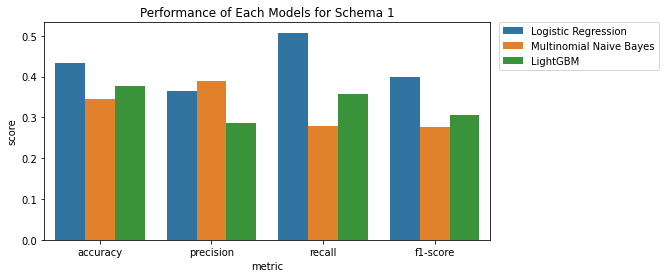

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(x="metric", y="score", hue="model", data=df_result)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Performance of Each Models for Schema 1")
plt.show()

## Schema 2

**Logistic Regression**

In [ ]:
print(f"Accuracy score: {round(accuracy_score(logreg_ypred, y_test_desc_count), 4)}")
print(f"Precision score: {round(precision_score(logreg_ypred, y_test_desc_count,average='macro'), 4)}")
print(f"Recall score: {round(recall_score(logreg_ypred, y_test_desc_count, average='macro'), 4)}")
print(f"F1 score: {round(f1_score(logreg_ypred, y_test_desc_count, average='macro'), 4)}")

Accuracy score: 0.4453
Precision score: 0.4146
Recall score: 0.512
F1 score: 0.4378


**Multinomial Naive Bayes**

In [ ]:
print(f"Accuracy score: {round(accuracy_score(mnb_ypred,  y_test_desc_count), 4)}")
print(f"Precision score: {round(precision_score(mnb_ypred,  y_test_desc_count,average='macro'), 4)}")
print(f"Recall score: {round(recall_score(mnb_ypred,  y_test_desc_count, average='macro'), 4)}")
print(f"F1 score: {round(f1_score(mnb_ypred,  y_test_desc_count, average='macro'), 4)}")

Accuracy score: 0.3802
Precision score: 0.445
Recall score: 0.3337
F1 score: 0.3246


**LightGBM**

In [ ]:
print(f"Accuracy score: {round(accuracy_score(lgb_ypred, y_test_desc_count), 4)}")
print(f"Precision score: {round(precision_score(lgb_ypred, y_test_desc_count,average='macro'), 4)}")
print(f"Recall score: {round(recall_score(lgb_ypred, y_test_desc_count,average='macro'), 4)}")
print(f"F1 score: {round(f1_score(lgb_ypred, y_test_desc_count,average='macro'), 4)}")

Accuracy score: 0.4349
Precision score: 0.3613
Recall score: 0.4863
F1 score: 0.3835


**Result**

In [ ]:
df_result = pd.DataFrame({
    "model": ["Logistic Regression", "Multinomial Naive Bayes", "LightGBM"]*4,
    "score": [0.4453, 0.3802, 0.4349,
              0.4146, 0.445, 0.3613,
               0.512, 0.3337, 0.4863,
              0.4378, 0.3246, 0.3835],
    "metric": ["accuracy"]*3 + ["precision"]*3 + ["recall"]*3 + ["f1-score"]*3
})

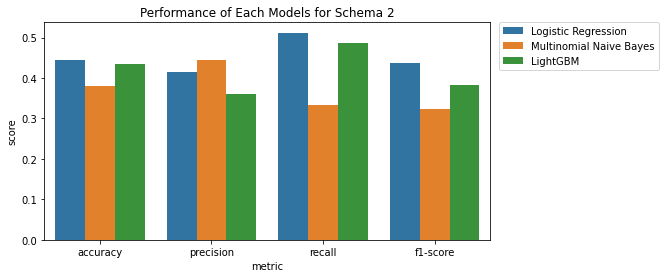

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(x="metric", y="score", hue="model", data=df_result)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Performance of Each Models for Schema 2")
plt.show()

## Schema 3

**Logistic Regression**

In [40]:
print(f"Accuracy score: {round(accuracy_score(logreg_ypred, y_test_fill), 4)}")
print(f"Precision score: {round(precision_score(logreg_ypred, y_test_fill,average='macro'), 4)}")
print(f"Recall score: {round(recall_score(logreg_ypred, y_test_fill, average='macro'), 4)}")
print(f"F1 score: {round(f1_score(logreg_ypred, y_test_fill, average='macro'), 4)}")

Accuracy score: 0.7718
Precision score: 0.4898
Recall score: 0.6363
F1 score: 0.5216


**Multinomial Naive Bayes**

In [41]:
print(f"Accuracy score: {round(accuracy_score(mnb_ypred,  y_test_fill), 4)}")
print(f"Precision score: {round(precision_score(mnb_ypred,  y_test_fill,average='macro'), 4)}")
print(f"Recall score: {round(recall_score(mnb_ypred,  y_test_fill, average='macro'), 4)}")
print(f"F1 score: {round(f1_score(mnb_ypred,  y_test_fill, average='macro'), 4)}")

Accuracy score: 0.699
Precision score: 0.6885
Recall score: 0.3805
F1 score: 0.4361


**LightGBM**

In [42]:
print(f"Accuracy score: {round(accuracy_score(lgb_ypred, y_test_fill), 4)}")
print(f"Precision score: {round(precision_score(lgb_ypred, y_test_fill,average='macro'), 4)}")
print(f"Recall score: {round(recall_score(lgb_ypred, y_test_fill,average='macro'), 4)}")
print(f"F1 score: {round(f1_score(lgb_ypred, y_test_fill,average='macro'), 4)}")

Accuracy score: 0.7488
Precision score: 0.4101
Recall score: 0.5617
F1 score: 0.4522


**Result**

In [43]:
df_result = pd.DataFrame({
    "model": ["Logistic Regression", "Multinomial Naive Bayes", "LightGBM"]*4,
    "score": [0.7718, 0.699, 0.7488,
              0.4898, 0.6885,  0.4101,
               0.6363, 0.3805, 0.5617,
              0.5216, 0.4361, 0.4522],
    "metric": ["accuracy"]*3 + ["precision"]*3 + ["recall"]*3 + ["f1-score"]*3
})

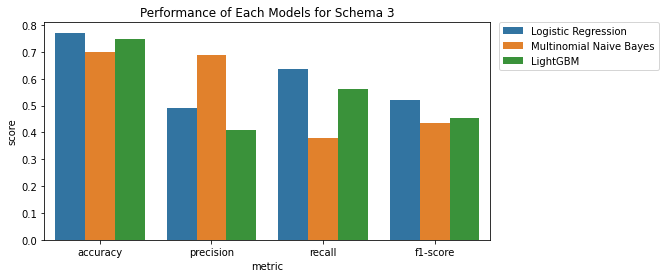

In [44]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(x="metric", y="score", hue="model", data=df_result)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Performance of Each Models for Schema 3")
plt.show()

## Schema 4

**Logistic Regression**

In [40]:
print(f"Accuracy score: {round(accuracy_score(logreg_ypred, y_test_tweet), 4)}")
print(f"Precision score: {round(precision_score(logreg_ypred, y_test_tweet,average='macro'), 4)}")
print(f"Recall score: {round(recall_score(logreg_ypred, y_test_tweet, average='macro'), 4)}")
print(f"F1 score: {round(f1_score(logreg_ypred, y_test_tweet, average='macro'), 4)}")

Accuracy score: 0.5682
Precision score: 0.3774
Recall score: 0.4291
F1 score: 0.3928


**Multinomial Naive Bayes**

In [41]:
print(f"Accuracy score: {round(accuracy_score(mnb_ypred,  y_test_tweet), 4)}")
print(f"Precision score: {round(precision_score(mnb_ypred,  y_test_tweet,average='macro'), 4)}")
print(f"Recall score: {round(recall_score(mnb_ypred,  y_test_tweet, average='macro'), 4)}")
print(f"F1 score: {round(f1_score(mnb_ypred,  y_test_tweet, average='macro'), 4)}")

Accuracy score: 0.4864
Precision score: 0.549
Recall score: 0.4334
F1 score: 0.4542


**LightGBM**

In [42]:
print(f"Accuracy score: {round(accuracy_score(lgb_ypred, y_test_tweet), 4)}")
print(f"Precision score: {round(precision_score(lgb_ypred, y_test_tweet,average='macro'), 4)}")
print(f"Recall score: {round(recall_score(lgb_ypred, y_test_tweet,average='macro'), 4)}")
print(f"F1 score: {round(f1_score(lgb_ypred, y_test_tweet,average='macro'), 4)}")

Accuracy score: 0.5955
Precision score: 0.3535
Recall score: 0.5619
F1 score: 0.4067


**Result**

In [43]:
df_result = pd.DataFrame({
    "model": ["Logistic Regression", "Multinomial Naive Bayes", "LightGBM"]*4,
    "score": [0.5682, 0.4864, 0.5955,
              0.3774, 0.549, 0.5955,
               0.4291, 0.4334, 0.5619,
              0.3928, 0.4542, 0.4067],
    "metric": ["accuracy"]*3 + ["precision"]*3 + ["recall"]*3 + ["f1-score"]*3
})

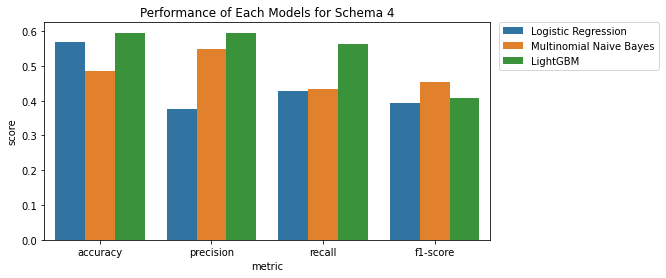

In [44]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(x="metric", y="score", hue="model", data=df_result)

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Performance of Each Models for Schema 4")
plt.show()

# Occupational Area Classification

## Data testing profile

In [46]:
X_train_final, X_test, y_train_ovs, y_test = [], [], [], []

In [47]:
X, y = [], []

In [49]:
df_test = pd.read_excel(dataset_path+"df_testing_structured.xlsx")
df_test.head()

,id,created_at,description,followers_count,following_count,listed_count,location,name,tweet_count,username,verified
0,1.0,2017-05-12,A place to record the insights I receive on th...,94952.0,427.0,59.0,Inquiry: aisykaspol@gmail.com,‏َ,26004.0,lilithkis,0.0
1,2.0,2012-03-09,Official Twitter of Mario Teguh. \nAdmin@exnal...,9181064.0,0.0,3007.0,"Jakarta, Indonesia",Mario Teguh,55031.0,marioteguh,1.0
2,3.0,2019-11-15,Apprentice Python programmer :)\n\nhttps://t.c...,25.0,217.0,1.0,NaN,Florentin Anggraini Purnama,51.0,flo_and_behold,0.0
3,4.0,2013-04-10,A proud Indonesian. Bangga Berbangsa.,1049638.0,309.0,402.0,Indonesia,Gita Wirjawan,17653.0,gwirjawan,1.0
4,5.0,2012-01-11,Chairman MNC Group | Ketum Partai Perindo | Ke...,551980.0,374.0,375.0,Jakarta Capital Region,Hary Tanoesoedibjo,9185.0,hary_tanoe,1.0


In [51]:
df_test_profile = df_test[['description']]
df_test_profile['description'].fillna('', inplace=True)

In [52]:
raw_desc = df_test_profile['description']
clean_desc_test = np.array(pra_pemrosesan(raw_desc))

100%|██████████| 1054/1054 [00:05<00:00, 201.69it/s]


In [53]:
df_test_profile['clean_desc'] = clean_desc_test
X = vectorizer_desc_fill_tfidf.transform(df_test_profile['clean_desc']).todense()

In [55]:
y_pred = logreg_clf.predict(X)

In [56]:
df_res = pd.DataFrame({
    'id': [i for i in range(1, 1055)],
    'occupation': y_pred
})

In [57]:
df_res.to_csv('schema3-logreg.csv', header=False, index=False)

## Data testing Tweet

In [45]:
df_test = pd.read_csv(dataset_path+"df_testing_tweet.csv")
df_test.head()

,username,tweet
0,lilithkis,@swastiacintya @novemberdad Ya kamu<SEP>@swast...
1,marioteguh,NANTI SORE di https://t.co/h0sTzI6kj1 MTLV -...
2,flo_and_behold,Yaay! It was a fun session! :)
3,gwirjawan,Special screening film Nussa kemarin bareng pa...
4,hary_tanoe,"Pagi ini, Kamis, 27 Mei 2021, saya menerima ku..."


In [46]:
df_test['tweet'] = df_test['tweet'].astype(str)

In [47]:
df_test['num_tweet'] = df_test['tweet'].apply(lambda tweet: len(tweet.split("<SEP>")))

In [48]:
for idx, row in df_test.iterrows():
  # set the limit to max 250

  # split each tweet into a list of tweets
  list_tweet = row['tweet'].split("<SEP>")

  if row['num_tweet'] > 250:
    random_list_tweet = np.random.choice(list_tweet, 250, replace=False)
    df_test.at[idx, 'tweet'] = ' '.join(random_list_tweet)
  else:
    df_test.at[idx, 'tweet'] =' '.join(list_tweet)

In [49]:
stopwords = pd.read_csv("stopwordsID.csv", header=None)
df_kamus_singkatan = pd.read_csv('kamus_singkatan.csv')
df_kamus_alay = pd.read_csv('colloquial-indonesian-lexicon.csv')

raw_tweet = df_test['tweet']
clean_tweet = np.array(pra_pemrosesan(raw_tweet))

In [49]:
df_res = pd.DataFrame({
    'tweet': clean_tweet,
})

In [ ]:
df_res.to_csv(path+'CODE/df_test_clean_tweet_occupation.csv')

In [52]:
# load clean test tweet
df_test = pd.read_csv(path+'df_test_clean_tweet_occupation.csv')

In [53]:
df_test.fillna('', inplace=True)

In [59]:
X = vectorizer_tweet_tfidf.transform(df_test['tweet']).todense()

In [60]:
y_pred = multinb_clf.predict(X)

In [61]:
df_res = pd.DataFrame({
    'id': [i for i in range(1, 1055)],
    'occupation': y_pred
})

In [62]:
df_res.to_csv('schema4-multinb.csv', header=False, index=False)

In [ ]:
X = []